In [73]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score

from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.base import BaseEstimator

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from graphviz import Source
from sklearn import tree

RANDOM_STATE = 12

# import custom classes for pipeline
from prep import FeatureGemerator, FeatureSelector

In [74]:
# load_data 
df = pd.read_csv("BPL.csv")
df.sample(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
4789,4790,58,34,84,95120,4,1.6,2,0,0,0,0,1,0
2602,2603,52,26,161,93108,4,4.3,1,0,1,0,1,1,1
1585,1586,57,31,131,90502,2,2.7,1,0,0,0,0,0,0
2689,2690,40,16,104,91730,1,3.4,1,249,0,0,0,0,0
200,201,32,6,29,91355,1,1.9,3,0,0,0,0,1,1


In [75]:
# load grid_search results 
scoring_df = pd.read_csv('scoring_df.csv')
scoring_df

,model,accuracy,precision,recall,roc_auc,f1
0,CatBoostClassifier,0.982,0.953488,0.854167,0.924871,0.901099
1,RandomForestClassifier,0.980,0.952381,0.833333,0.914454,0.888889
2,DecisionTreeClassifier,0.980,0.941860,0.843750,0.919110,0.890110
3,GradientBoostingClassifier,0.979,0.941176,0.833333,0.913901,0.883978


In [76]:
# load pipeline
feature_engeneering_pipeline = joblib.load('data_engeneering_pipeline.pkl')
feature_engeneering_pipeline

Pipeline(steps=[('feature_generator', FeatureGemerator()),
                ('feature_selector', FeatureSelector())])

In [77]:
# load model
cb_classifier = joblib.load('models\\cb_model.pkl')

In [78]:
# concat_pipeline
model_pipeline = Pipeline([
        ('feature_engeneering_pipeline', feature_engeneering_pipeline),
        ('cb_classifier', cb_classifier)
    ])

model_pipeline

Pipeline(steps=[('feature_engeneering_pipeline',
                 Pipeline(steps=[('feature_generator', FeatureGemerator()),
                                 ('feature_selector', FeatureSelector())])),
                ('cb_classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002412CCB6348>)])

In [79]:
# train test split
target_col = ['Personal Loan']

X, y = df.drop(target_col, axis=1), df[target_col]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                            stratify = y, random_state=RANDOM_STATE)
metrics = {'accuracy': accuracy_score,
           'precision': precision_score,
           'recall': recall_score,
           'roc_auc': roc_auc_score, 
           'f1': f1_score}

In [80]:
%%time 

# stratified StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# scores
scoring = list(scoring_df.columns)[1:]
# print(f'Scoring columns: {scoring}')

scores = cross_validate(model_pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
scores.keys()

Wall time: 52.6 s


dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_roc_auc', 'test_f1'])

In [81]:
# cv_scores to dateframe
model_cv_scores = pd.DataFrame()
model_cv_scores['fold'] = np.arange(1, 6)

for score in scores:
    if 'test_' in score:
        model_cv_scores[score] = scores[score]
        
model_cv_scores

,fold,test_accuracy,test_precision,test_recall,test_roc_auc,test_f1
0,1,0.988,1.000000,0.875000,0.995829,0.933333
1,2,0.983,0.964706,0.854167,0.997430,0.906077
2,3,0.989,0.977528,0.906250,0.998963,0.940541
3,4,0.989,0.947368,0.937500,0.998099,0.942408
4,5,0.989,0.988506,0.895833,0.998848,0.939891


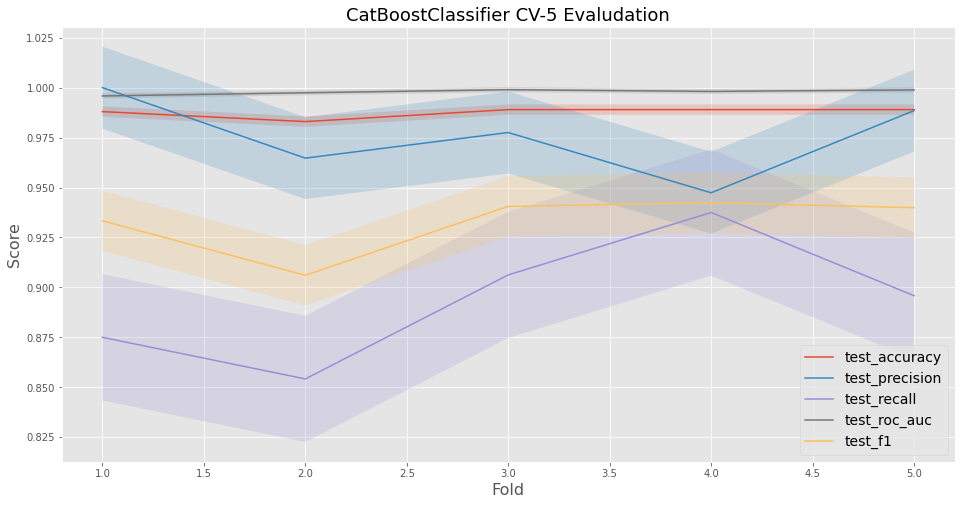

In [96]:
# vizualization
std_coef = 1.

plt.figure(figsize=(16, 8))

for column in model_cv_scores:
    if column != 'fold':
        plt.plot(model_cv_scores['fold'], model_cv_scores[column], label=column)
        plt.fill_between(x=model_cv_scores['fold'], 
                         y1=model_cv_scores[column]+std_coef*model_cv_scores[column].std(),
                         y2=model_cv_scores[column]-std_coef*model_cv_scores[column].std(),
                         alpha=.2)
        
        
plt.title('CatBoostClassifier CV-5 Evaludation', size=18)
plt.xlabel('Fold', size=16)
plt.ylabel('Score', size=16)

plt.legend(loc='lower right', fontsize=14);